# Load Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load Data

In [ ]:
# Run this only when you run the script using google colaboratory
from google.colab import drive
drive.mount('/content/drive')

import os
# adjust the path with your own google drive folder path
os.chdir("/content/drive/My Drive/Webinar/rfm_segmentation")

In [2]:
# download dataset https://www.kaggle.com/carrie1/ecommerce-data
dataset = pd.read_csv("ecommerce_data.csv",encoding= 'unicode_escape')
dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.00,France


# Dataset Preprocessing

In [4]:
# remove rows that have missing value
dataset = dataset.dropna()

# preprocess datatype and add some new features
dataset["Sales"] = dataset["Quantity"] * dataset["UnitPrice"]
dataset["InvoiceDate"] = pd.to_datetime(dataset["InvoiceDate"])
dataset["CustomerID"] = dataset["CustomerID"].astype("int64")
dataset["InvoiceDate_date"] = dataset["InvoiceDate"].dt.date
dataset["monthyear"] = pd.to_datetime(dataset["InvoiceDate"]).dt.to_period('M').dt.to_timestamp()
dataset = dataset[dataset.Sales>0]

# define month year period
dataset = dataset[dataset.monthyear<"2011-12"]

dataset.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,InvoiceDate_date,monthyear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010-12-01,2010-12-01
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010-12-01,2010-12-01
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010-12-01,2010-12-01
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010-12-01,2010-12-01
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,2010-12-01,2010-12-01


# Dataset Exploration

In [5]:
# see the data distribution each month
sales_monthly = dataset.groupby("monthyear").agg({"Sales":"sum","CustomerID":"nunique","InvoiceNo":"nunique"}).reset_index()
sales_monthly["Sales_per_trx"] = sales_monthly["Sales"] / sales_monthly["InvoiceNo"]
sales_monthly

,monthyear,Sales,CustomerID,InvoiceNo,Sales_per_trx
0,2010-12-01,572713.89,885,1400,409.08
1,2011-01-01,569445.04,741,987,576.95
2,2011-02-01,447137.35,758,997,448.48
3,2011-03-01,595500.76,974,1321,450.80
4,2011-04-01,469200.36,856,1149,408.36
5,2011-05-01,678594.56,1056,1555,436.40
6,2011-06-01,661213.69,991,1393,474.67
7,2011-07-01,600091.01,949,1331,450.86
8,2011-08-01,645343.90,935,1280,504.17
9,2011-09-01,952838.38,1266,1755,542.93


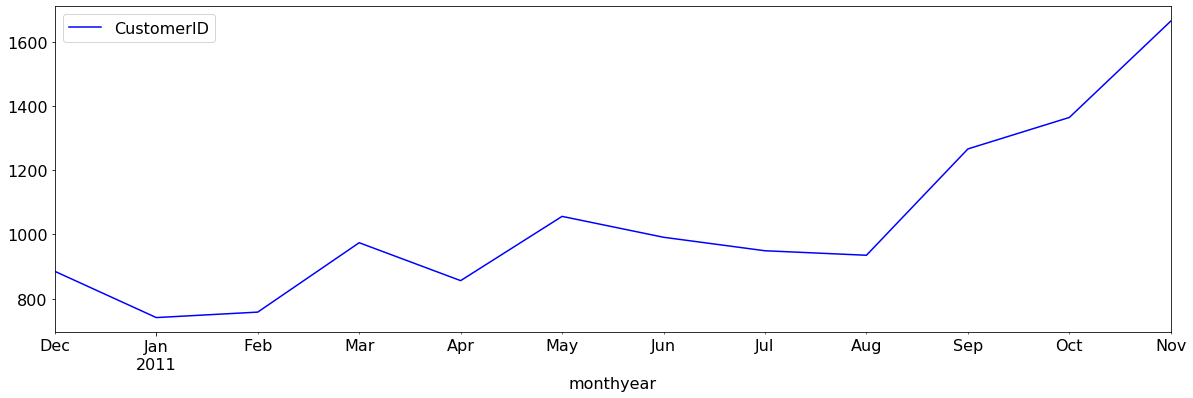

In [6]:
# plot customer
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
sales_monthly.plot(kind='line',x='monthyear',y='CustomerID',color='blue')
plt.show()

In [7]:
# Calculate Recency (month), Frequency (unique InvoiceNo), and Monetary (Sales) by Customer ID
customer_agg = dataset.groupby("CustomerID").agg({"monthyear":"max","Sales":"sum","InvoiceNo":"nunique"}).reset_index()
customer_agg.columns = ["CustomerID","last_month","Monetary","Frequency"]

customer_agg["Recency"] =  ((pd.to_datetime("2011-12-01")  - customer_agg["last_month"])/np.timedelta64(1, 'M')
                           ).round().astype("int")
customer_agg

,CustomerID,last_month,Monetary,Frequency,Recency
0,12346,2011-01-01,77183.60,1,11
1,12347,2011-10-01,4085.18,6,2
2,12348,2011-09-01,1797.24,4,3
3,12349,2011-11-01,1757.55,1,1
4,12350,2011-02-01,334.40,1,10
...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9
4293,18281,2011-06-01,80.82,1,6
4294,18282,2011-08-01,100.21,1,4
4295,18283,2011-11-01,1886.88,15,1


In [8]:
# see the Recency, Frequency, and Monetary distribution
customer_agg[["Recency","Frequency","Monetary"]].describe()

,Recency,Frequency,Monetary
count,4297.00,4297.00,4297.00
mean,3.53,4.13,1953.27
std,3.18,7.41,8355.83
min,1.00,1.00,2.90
25%,1.00,1.00,304.47
50%,2.00,2.00,657.30
75%,5.00,4.00,1600.86
max,12.00,200.00,268478.00


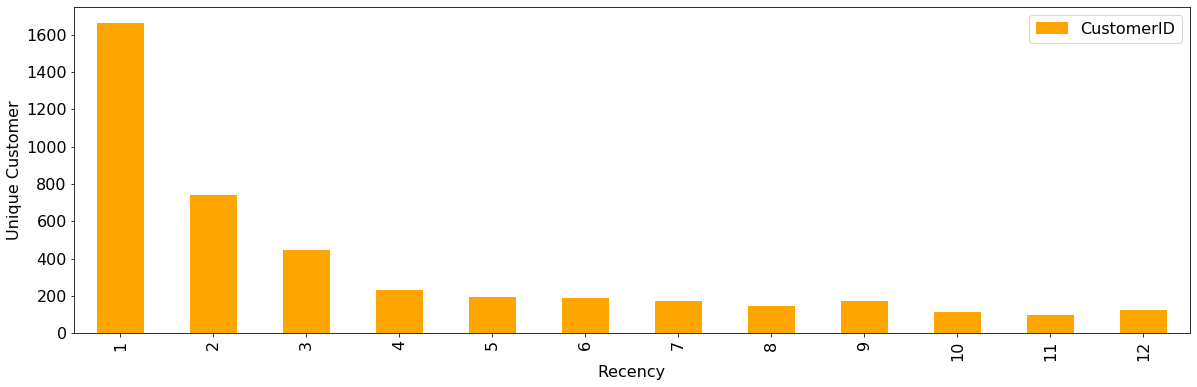

In [9]:
# Recency Distribution
recency_dist = customer_agg.groupby("Recency").agg({"CustomerID":"nunique"}).reset_index()
recency_dist.plot(kind='bar',x='Recency',y='CustomerID',color='orange',ylabel='Unique Customer')

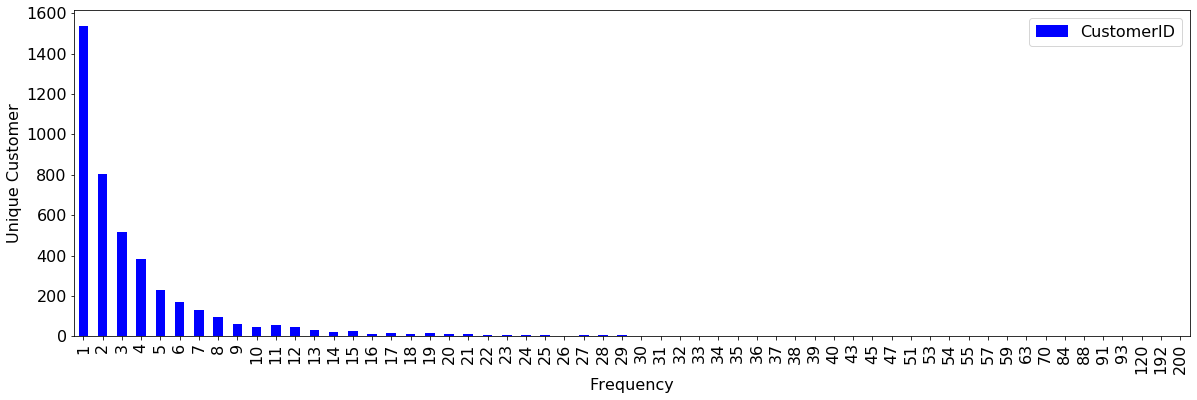

In [10]:
# Frequency Distribution
frequency_dist = customer_agg.groupby("Frequency").agg({"CustomerID":"nunique"}).reset_index()
frequency_dist.plot(kind='bar',x='Frequency',y='CustomerID',color='blue',ylabel='Unique Customer')

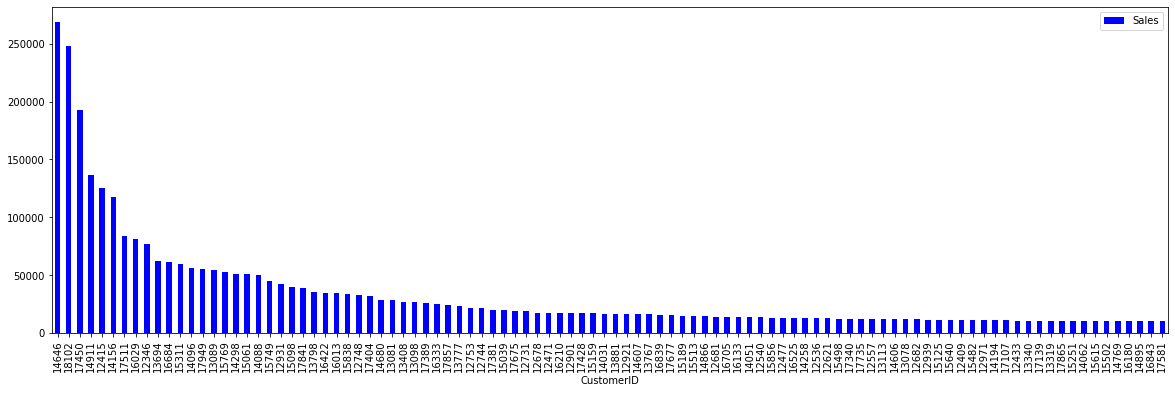

,CustomerID,Country,InvoiceNo,Description,Quantity,Sales,Sales_cum_sum,Sales_perc,Sales_cum_perc
1679,14646,Netherlands,70,698,188957,268478.00,268478.00,0.03,3.20
4169,18102,United Kingdom,57,162,61426,248171.76,516649.76,0.03,6.16
3700,17450,United Kingdom,45,125,69273,192988.39,709638.15,0.02,8.45
1868,14911,EIRE,192,1762,76319,136846.14,846484.29,0.02,10.09
56,12415,Australia,21,451,77374,124914.53,971398.82,0.01,11.57
1327,14156,EIRE,55,730,57885,117379.63,1088778.45,0.01,12.97
3743,17511,United Kingdom,29,440,57334,83683.06,1172461.51,0.01,13.97
2681,16029,United Kingdom,63,45,40208,81024.84,1253486.35,0.01,14.93
0,12346,United Kingdom,1,1,74215,77183.60,1330669.95,0.01,15.85
992,13694,United Kingdom,47,355,60872,61908.46,1392578.41,0.01,16.59


In [11]:
# see the customer with the highest sales
customer = dataset.groupby(["CustomerID","Country"]).agg({'InvoiceNo':'nunique','Description':'nunique','Quantity':'sum','Sales':'sum'}).reset_index()
customer = customer.sort_values("Sales",ascending=False)
customer['Sales_cum_sum'] = customer['Sales'].cumsum()
customer['Sales_perc'] = customer['Sales']/customer['Sales'].sum()
customer['Sales_cum_perc'] = 100*customer['Sales_cum_sum']/customer['Sales'].sum()
customer.to_csv("sales_by_customer.csv", index=False)

plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.grid'] = False
customer.head(100).plot(kind='bar',x='CustomerID',y='Sales',color='blue')
plt.show()

customer.head(20)

# Clustering using Rule-based

In [12]:
# https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python
# divide Recency, Frequency, and Monetary into 3 groups using quartile

## Recency
# recency thresold
recency_group = customer_agg.groupby("Recency").agg({"CustomerID":"nunique"}).reset_index().sort_values("Recency")
recency_group['customerid_cumsum'] = recency_group['CustomerID'].cumsum()
recency_group['perc'] = recency_group['CustomerID']/recency_group['CustomerID'].sum()
recency_group['cum_perc'] = recency_group['customerid_cumsum']/recency_group['CustomerID'].sum()

first_perc = 0.33
first_thresold = recency_group[recency_group.cum_perc >= first_perc].Recency.min()
second_perc = (1 - recency_group[recency_group.Recency > first_thresold].cum_perc.min()
              )/2 + recency_group[recency_group.cum_perc >= first_perc].cum_perc.min()
second_thresold = recency_group[recency_group.cum_perc >= second_perc].Recency.min()

# recency segment
customer_agg.loc[customer_agg["Recency"] <= first_thresold,"r_group"] = 3
customer_agg.loc[(customer_agg["Recency"] > first_thresold) & (customer_agg["Recency"] <= second_thresold),"r_group"] = 2
customer_agg.loc[customer_agg["Recency"] > second_thresold,"r_group"] = 1

## Frequency
# frequency thresold
frequency_group = customer_agg.groupby("Frequency").agg({"CustomerID":"nunique"}).reset_index().sort_values("Frequency")
frequency_group['customerid_cumsum'] = frequency_group['CustomerID'].cumsum()
frequency_group['perc'] = frequency_group['CustomerID']/frequency_group['CustomerID'].sum()
frequency_group['cum_perc'] = frequency_group['customerid_cumsum']/frequency_group['CustomerID'].sum()

first_perc = 0.33
first_thresold = frequency_group[frequency_group.cum_perc >= first_perc].Frequency.min()
second_perc = (1 - frequency_group[frequency_group.Frequency > first_thresold].cum_perc.min())/2 + frequency_group[frequency_group.cum_perc >= first_perc].cum_perc.min()
second_thresold = frequency_group[frequency_group.cum_perc >= second_perc].Frequency.min()

# frequency segment
customer_agg.loc[customer_agg["Frequency"] <= first_thresold,"f_group"] = 1
customer_agg.loc[(customer_agg["Frequency"] > first_thresold) & (customer_agg["Frequency"] <= second_thresold),"f_group"] = 2
customer_agg.loc[customer_agg["Frequency"] > second_thresold,"f_group"] = 3

## Monetary
# monetary thresold
monetary_group = customer_agg.groupby("Monetary").agg({"CustomerID":"nunique"}).reset_index().sort_values("Monetary")
monetary_group['customerid_cumsum'] = monetary_group['CustomerID'].cumsum()
monetary_group['perc'] = monetary_group['CustomerID']/monetary_group['CustomerID'].sum()
monetary_group['cum_perc'] = monetary_group['customerid_cumsum']/monetary_group['CustomerID'].sum()
monetary_group

first_perc = 0.33
first_thresold = monetary_group[monetary_group.cum_perc >= first_perc].Monetary.min()
second_perc = (1 - monetary_group[monetary_group.Monetary > first_thresold].cum_perc.min())/2 + monetary_group[monetary_group.cum_perc >= first_perc].cum_perc.min()
second_thresold = monetary_group[monetary_group.cum_perc >= second_perc].Monetary.min()

# monetary segment
customer_agg.loc[customer_agg["Monetary"] <= first_thresold,"m_group"] = 1
customer_agg.loc[(customer_agg["Monetary"] > first_thresold) & (customer_agg["Monetary"] <= second_thresold),"m_group"] = 2
customer_agg.loc[customer_agg["Monetary"] > second_thresold,"m_group"] = 3

customer_agg["rfm_score"] = customer_agg["r_group"] + customer_agg["f_group"] + customer_agg["m_group"]
customer_agg[["CustomerID","Recency","Frequency","Monetary","r_group","f_group","m_group","rfm_score"]].head(10)

,CustomerID,Recency,Frequency,Monetary,r_group,f_group,m_group,rfm_score
0,12346,11,1,77183.60,1.00,1.00,3.00,5.00
1,12347,2,6,4085.18,2.00,3.00,3.00,8.00
2,12348,3,4,1797.24,2.00,3.00,3.00,8.00
3,12349,1,1,1757.55,3.00,1.00,3.00,7.00
4,12350,10,1,334.40,1.00,1.00,1.00,3.00
5,12352,1,8,2506.04,3.00,3.00,3.00,9.00
6,12353,7,1,89.00,1.00,1.00,1.00,3.00
7,12354,8,1,1079.40,1.00,1.00,2.00,4.00
8,12355,7,1,459.40,1.00,1.00,2.00,4.00
9,12356,1,3,2811.43,3.00,2.00,3.00,8.00


In [13]:
# label the segment based on rule based for each Recency, Frequency, or Monetary combination

customer_agg["rfm_segment"] = None
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.rfm_score==9), "rfm_segment"] = "1. Champion"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.rfm_score==8), "rfm_segment"] = "2. Loyal"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group.isin([2,3]))&
                 (customer_agg.rfm_score==7), "rfm_segment"] = "3. Potential Loyalist"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group==3)&
                 (customer_agg.rfm_score.isin([5,6,7])), "rfm_segment"] = "4. Recent Customer"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.r_group==1)&
                 (customer_agg.rfm_score.isin([6,7])), "rfm_segment"] = "5. Cannot Lose Them"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.rfm_score==6),
                 "rfm_segment"] = "6. Average"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.rfm_score.isin([4,5])), 
                 "rfm_segment"] = "7. About to Sleep"
customer_agg.loc[(customer_agg.rfm_segment.isnull())&(customer_agg.rfm_score==3), 
                 "rfm_segment"] = "8. Lost Customer"

customer_agg[["CustomerID","Recency","Frequency","Monetary","r_group","f_group","m_group","rfm_segment"]].head(10)

,CustomerID,Recency,Frequency,Monetary,r_group,f_group,m_group,rfm_segment
0,12346,11,1,77183.60,1.00,1.00,3.00,7. About to Sleep
1,12347,2,6,4085.18,2.00,3.00,3.00,2. Loyal
2,12348,3,4,1797.24,2.00,3.00,3.00,2. Loyal
3,12349,1,1,1757.55,3.00,1.00,3.00,3. Potential Loyalist
4,12350,10,1,334.40,1.00,1.00,1.00,8. Lost Customer
5,12352,1,8,2506.04,3.00,3.00,3.00,1. Champion
6,12353,7,1,89.00,1.00,1.00,1.00,8. Lost Customer
7,12354,8,1,1079.40,1.00,1.00,2.00,7. About to Sleep
8,12355,7,1,459.40,1.00,1.00,2.00,7. About to Sleep
9,12356,1,3,2811.43,3.00,2.00,3.00,2. Loyal


In [14]:
# see segment distribution
segment_dist = customer_agg.groupby("rfm_segment").agg({"CustomerID":"nunique",
                                                        "Recency":["min","max","mean"],
                                                        "Frequency":["min","max","mean","sum"],
                                                        "Monetary":["min","max","mean","sum"]}).reset_index()
segment_dist

rfm_segment CustomerID Recency          Frequency             \
                            nunique     min max mean       min  max  mean   
0            1. Champion        779       1   1 1.00         4  200 11.99   
1               2. Loyal        522       1   3 1.68         2   21  5.32   
2  3. Potential Loyalist        461       1   3 1.55         1    9  2.95   
3     4. Recent Customer        358       1   1 1.00         1    3  1.32   
4    5. Cannot Lose Them        199       4  12 5.65         2   34  4.41   
5             6. Average        260       2   3 2.43         1    5  2.31   
6      7. About to Sleep       1067       2  12 4.95         1    6  1.57   
7       8. Lost Customer        651       4  12 8.29         1    1  1.00   

        Monetary                               
    sum      min       max    mean        sum  
0  9343  1153.62 268478.00 6807.27 5302866.91  
1  2776   414.76  21279.29 2166.92 1131129.74  
2  1359    36.56  12601.83 1035.67  477444.52  
3   473    20.80   1060.25  289.54  103656.98  
4   877   404.58  44534.30 2238.56  445472.53  
5   600   226.75   4366.78  812.73  211310.79  
6  1675     6.20  77183.60  555.77  593002.22  
7   651     2.90    380.50  197.13  128331.42

In [15]:
segment_dist.columns = ["rfm_segment","unique_customer","min_r","max_r","mean_r",
                        "min_f","max_f","mean_f","sum_f",
                        "min_m","max_m","mean_m","sum_m"]
segment_dist["perc_customer"] = segment_dist["unique_customer"] / segment_dist["unique_customer"].sum()
segment_dist["perc_monetary"] = segment_dist["sum_m"] / segment_dist["sum_m"].sum()
segment_dist["perc_frequency"] = segment_dist["sum_f"] / segment_dist["sum_f"].sum()
segment_dist

,rfm_segment,unique_customer,min_r,max_r,mean_r,min_f,max_f,mean_f,sum_f,min_m,max_m,mean_m,sum_m,perc_customer,perc_monetary,perc_frequency
0,1. Champion,779,1,1,1.00,4,200,11.99,9343,1153.62,268478.00,6807.27,5302866.91,0.18,0.63,0.53
1,2. Loyal,522,1,3,1.68,2,21,5.32,2776,414.76,21279.29,2166.92,1131129.74,0.12,0.13,0.16
2,3. Potential Loyalist,461,1,3,1.55,1,9,2.95,1359,36.56,12601.83,1035.67,477444.52,0.11,0.06,0.08
3,4. Recent Customer,358,1,1,1.00,1,3,1.32,473,20.80,1060.25,289.54,103656.98,0.08,0.01,0.03
4,5. Cannot Lose Them,199,4,12,5.65,2,34,4.41,877,404.58,44534.30,2238.56,445472.53,0.05,0.05,0.05
5,6. Average,260,2,3,2.43,1,5,2.31,600,226.75,4366.78,812.73,211310.79,0.06,0.03,0.03
6,7. About to Sleep,1067,2,12,4.95,1,6,1.57,1675,6.20,77183.60,555.77,593002.22,0.25,0.07,0.09
7,8. Lost Customer,651,4,12,8.29,1,1,1.00,651,2.90,380.50,197.13,128331.42,0.15,0.02,0.04


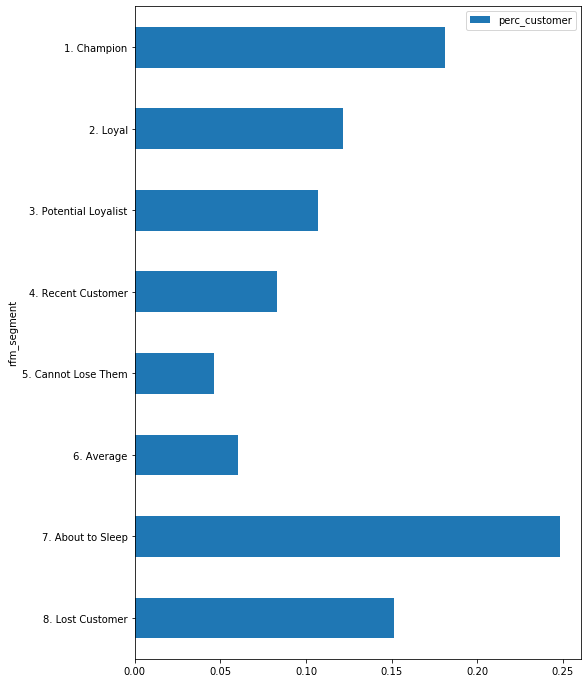

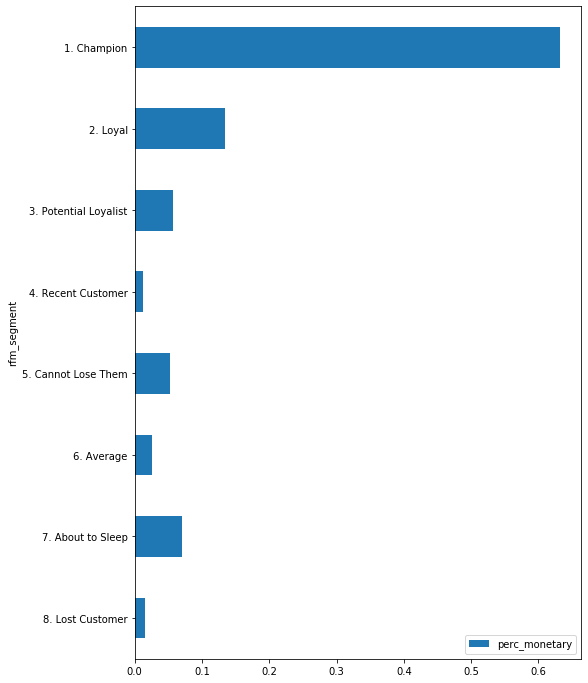

In [16]:
# plot perc customer
plt.rcParams["figure.figsize"] = [8, 12]
plt.rcParams['axes.grid'] = False
segment_dist.sort_values("rfm_segment",ascending=False).plot(kind='barh',x='rfm_segment',y='perc_customer')
plt.show()

# plot perc monetary
plt.rcParams["figure.figsize"] = [8, 12]
plt.rcParams['axes.grid'] = False
segment_dist.sort_values("rfm_segment",ascending=False).plot(kind='barh',x='rfm_segment',y='perc_monetary')
plt.show()

# Clustering using K-Means

In [17]:
# https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf
# since the data are skewed, we transform it to log 
customer_agg["Monetary_log"]= np.log(customer_agg[['Monetary']])
customer_agg["Frequency_log"]= np.log(customer_agg[['Frequency']])
customer_agg["Recency_log"]= np.log(customer_agg[['Recency']])
customer_agg

,CustomerID,last_month,Monetary,Frequency,Recency,r_group,f_group,m_group,rfm_score,rfm_segment,Monetary_log,Frequency_log,Recency_log
0,12346,2011-01-01,77183.60,1,11,1.00,1.00,3.00,5.00,7. About to Sleep,11.25,0.00,2.40
1,12347,2011-10-01,4085.18,6,2,2.00,3.00,3.00,8.00,2. Loyal,8.32,1.79,0.69
2,12348,2011-09-01,1797.24,4,3,2.00,3.00,3.00,8.00,2. Loyal,7.49,1.39,1.10
3,12349,2011-11-01,1757.55,1,1,3.00,1.00,3.00,7.00,3. Potential Loyalist,7.47,0.00,0.00
4,12350,2011-02-01,334.40,1,10,1.00,1.00,1.00,3.00,8. Lost Customer,5.81,0.00,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9,1.00,1.00,1.00,3.00,8. Lost Customer,5.20,0.00,2.20
4293,18281,2011-06-01,80.82,1,6,1.00,1.00,1.00,3.00,8. Lost Customer,4.39,0.00,1.79
4294,18282,2011-08-01,100.21,1,4,1.00,1.00,1.00,3.00,8. Lost Customer,4.61,0.00,1.39
4295,18283,2011-11-01,1886.88,15,1,3.00,3.00,3.00,9.00,1. Champion,7.54,2.71,0.00


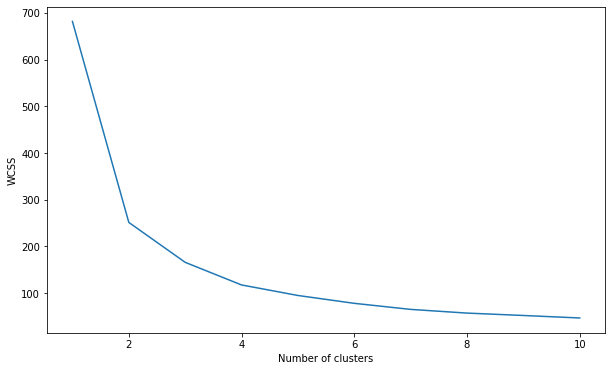

In [18]:
# Find k using elbow method
# https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
# Inertia: It is the sum of squared distances of samples to their closest cluster center.

# K-means
dataset_array = customer_agg[["Monetary_log","Frequency_log","Recency_log"]].values
scaler = MinMaxScaler()

X_scaled=scaler.fit_transform(dataset_array)
wcss = [] 
for i in range(1, 11): 
    k_model =  KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    k_model.fit(X_scaled)
    wcss.append(k_model.inertia_)

plt.rcParams["figure.figsize"] = [10, 6]
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show(wcss)

In [19]:
# K-means
dataset_array = customer_agg[["Monetary_log","Frequency_log","Recency_log"]].values
scaler = MinMaxScaler()

X_scaled=scaler.fit_transform(dataset_array)

k_model = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
k_model.fit(X_scaled)

predicted_values = k_model.predict(X_scaled)

predicted_values = pd.DataFrame(predicted_values, columns=["cluster_segment"])
dataset_cluster = pd.concat([customer_agg,predicted_values], axis=1)

In [20]:
# cluster distribution
cluster_dist = dataset_cluster.groupby("cluster_segment").agg({"CustomerID":"nunique","Frequency":["min","max","mean"],\
                                                               "Monetary":["min","max","mean"],\
                                                               "Recency":["min","max","mean"]}).reset_index()
cluster_dist

cluster_segment CustomerID Frequency            Monetary                    \
                     nunique       min  max  mean      min       max    mean   
0               0       1200         1   34  1.62     2.90  77183.60  624.47   
1               1        887         1    7  2.32    20.80   6207.67  719.61   
2               2       1331         1   17  2.56     6.20  12601.83  979.69   
3               3        879         3  200 11.77   621.68 268478.00 6486.46   

  Recency           
      min max mean  
0       4  12 8.07  
1       1   1 1.00  
2       2   5 2.71  
3       1   3 1.12

In [21]:
# Cluster Labeling
dataset_cluster.loc[dataset_cluster.cluster_segment==3,"rfm_segment"] = "1. Champion"
dataset_cluster.loc[dataset_cluster.cluster_segment==1,"rfm_segment"] = "2. Recent"
dataset_cluster.loc[dataset_cluster.cluster_segment==2,"rfm_segment"] = "3. Regular"
dataset_cluster.loc[dataset_cluster.cluster_segment==0,"rfm_segment"] = "4. Sleeping"
dataset_cluster

,CustomerID,last_month,Monetary,Frequency,Recency,r_group,f_group,m_group,rfm_score,rfm_segment,Monetary_log,Frequency_log,Recency_log,cluster_segment
0,12346,2011-01-01,77183.60,1,11,1.00,1.00,3.00,5.00,4. Sleeping,11.25,0.00,2.40,0
1,12347,2011-10-01,4085.18,6,2,2.00,3.00,3.00,8.00,1. Champion,8.32,1.79,0.69,3
2,12348,2011-09-01,1797.24,4,3,2.00,3.00,3.00,8.00,3. Regular,7.49,1.39,1.10,2
3,12349,2011-11-01,1757.55,1,1,3.00,1.00,3.00,7.00,2. Recent,7.47,0.00,0.00,1
4,12350,2011-02-01,334.40,1,10,1.00,1.00,1.00,3.00,4. Sleeping,5.81,0.00,2.30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,18280,2011-03-01,180.60,1,9,1.00,1.00,1.00,3.00,4. Sleeping,5.20,0.00,2.20,0
4293,18281,2011-06-01,80.82,1,6,1.00,1.00,1.00,3.00,4. Sleeping,4.39,0.00,1.79,0
4294,18282,2011-08-01,100.21,1,4,1.00,1.00,1.00,3.00,3. Regular,4.61,0.00,1.39,2
4295,18283,2011-11-01,1886.88,15,1,3.00,3.00,3.00,9.00,1. Champion,7.54,2.71,0.00,3


In [22]:
# cluster distribution
cluster_dist = dataset_cluster.groupby("rfm_segment").agg({"CustomerID":"nunique",\
                                                           "Frequency":["min","max","mean"],\
                                                           "Monetary":["min","max","mean"],\
                                                           "Recency":["min","max","mean"]}).reset_index()
cluster_dist

rfm_segment CustomerID Frequency            Monetary                    \
                  nunique       min  max  mean      min       max    mean   
0  1. Champion        879         3  200 11.77   621.68 268478.00 6486.46   
1    2. Recent        887         1    7  2.32    20.80   6207.67  719.61   
2   3. Regular       1331         1   17  2.56     6.20  12601.83  979.69   
3  4. Sleeping       1200         1   34  1.62     2.90  77183.60  624.47   

  Recency           
      min max mean  
0       1   3 1.12  
1       1   1 1.00  
2       2   5 2.71  
3       4  12 8.07

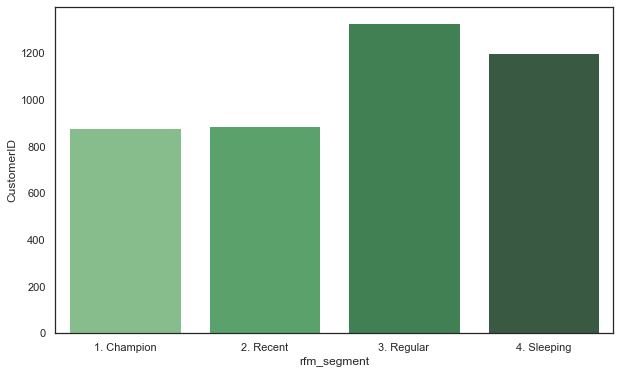

In [23]:
# plot the unique customer
user_dist = dataset_cluster.groupby("rfm_segment").agg({"CustomerID":"nunique"}).reset_index()
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="white", font_scale=1)
sns.barplot(data=user_dist,x='rfm_segment',y='CustomerID',palette="Greens_d",orient="v")

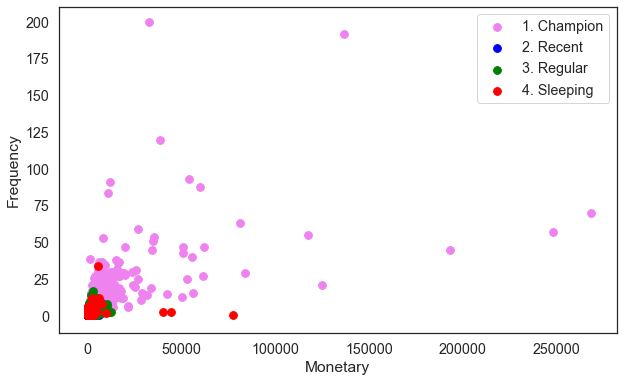

In [24]:
# 2d visualization
X = dataset_cluster

# Monetary x Frequency
plt.rcParams["figure.figsize"] = [10, 6]
sns.set_theme(style="white", font_scale=1.3)
plt.scatter(X[X.cluster_segment == 3].Monetary, X[X.cluster_segment == 3].Frequency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Monetary, X[X.cluster_segment == 1].Frequency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Monetary, X[X.cluster_segment == 2].Frequency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Monetary, X[X.cluster_segment == 0].Frequency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

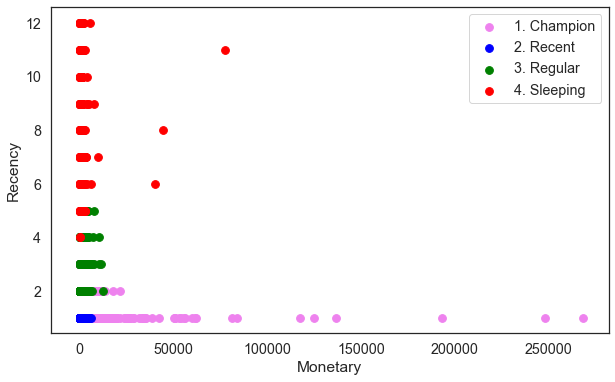

In [25]:
# Monetary x Recency
plt.scatter(X[X.cluster_segment == 3].Monetary, X[X.cluster_segment == 3].Recency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Monetary, X[X.cluster_segment == 1].Recency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Monetary, X[X.cluster_segment == 2].Recency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Monetary, X[X.cluster_segment == 0].Recency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Monetary') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

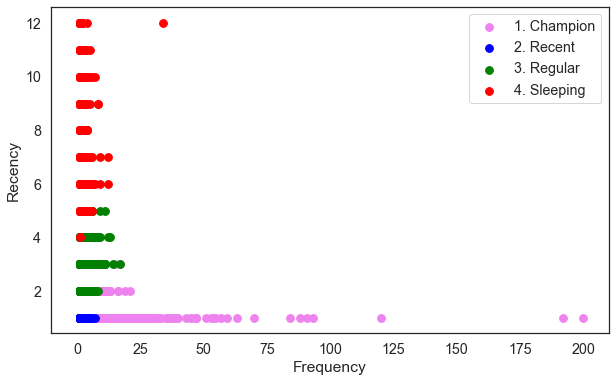

In [26]:
# Monetary x Frequency
plt.scatter(X[X.cluster_segment == 3].Frequency, X[X.cluster_segment == 3].Recency, s = 60, c = 'violet', label = '1. Champion')
plt.scatter(X[X.cluster_segment == 1].Frequency, X[X.cluster_segment == 1].Recency, s = 60, c = 'blue', label = '2. Recent')
plt.scatter(X[X.cluster_segment == 2].Frequency, X[X.cluster_segment == 2].Recency, s = 60, c = 'green', label = '3. Regular')
plt.scatter(X[X.cluster_segment == 0].Frequency, X[X.cluster_segment == 0].Recency, s = 60, c = 'red', label = '4. Sleeping')
plt.xlabel('Frequency') 
plt.ylabel('Recency') 
plt.legend() 
plt.show()

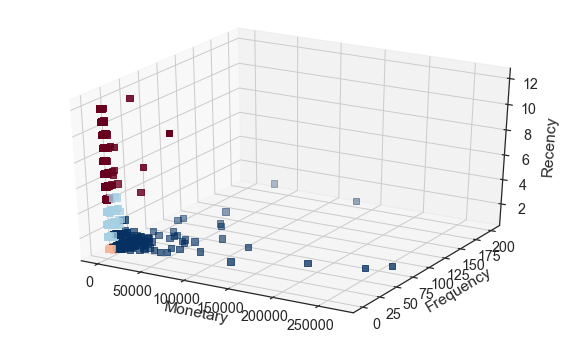

In [27]:
# 3d visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(dataset_cluster['Monetary'])
y = np.array(dataset_cluster['Frequency'])
z = np.array(dataset_cluster['Recency'])

xLabel = ax.set_xlabel('Monetary')
yLabel = ax.set_ylabel('Frequency')
zLabel = ax.set_zlabel('Recency')

ax.scatter(x,y,z, marker="s", c=dataset_cluster["cluster_segment"], s=40, cmap="RdBu")
plt.rcParams["figure.figsize"] = [20, 15]

plt.show()